# Yellowstone Seismic Analysis
Ess314 Yuyang Dai

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
from pyrocko import cake
import harmonica as hm
import verde as vd

# Set up matplotlib
plt.style.use('seaborn-v0_8') 
%matplotlib inline

In [37]:
# Load refraction and reflection data
refraction_df = pd.read_csv("yellowstone_refractions.csv")
reflection_df = pd.read_csv("yellowstone_reflections.csv")

# Preview the data
refraction_df.head(), reflection_df.head()

(   Unnamed: 0  X distance [m]  P wave arrivals [s]
 0           0          1050.0             0.434797
 1           1          1050.0             0.434797
 2           2          2050.0             0.696565
 3           3          2050.0             0.696565
 4           4          3050.0             0.958332,
    Unnamed: 0  X distance [m]  P wave arrival 1 [s]  P wave arrival 2 [s]  \
 0           0            50.0              0.226764              0.853870   
 1           1          1050.0              0.449909              0.903222   
 2           2          2050.0              0.792435              1.028870   
 3           3          3050.0              1.152400              1.205666   
 4           4          4050.0              1.517445              1.413074   
 
    P wave arrival 3 [s]  P wave arrival 4 [s]  
 0              1.850956              2.789503  
 1              1.866524              2.797473  
 2              1.909640              2.819794  
 3              1.978

## 1. Seismic Refraction Analysis

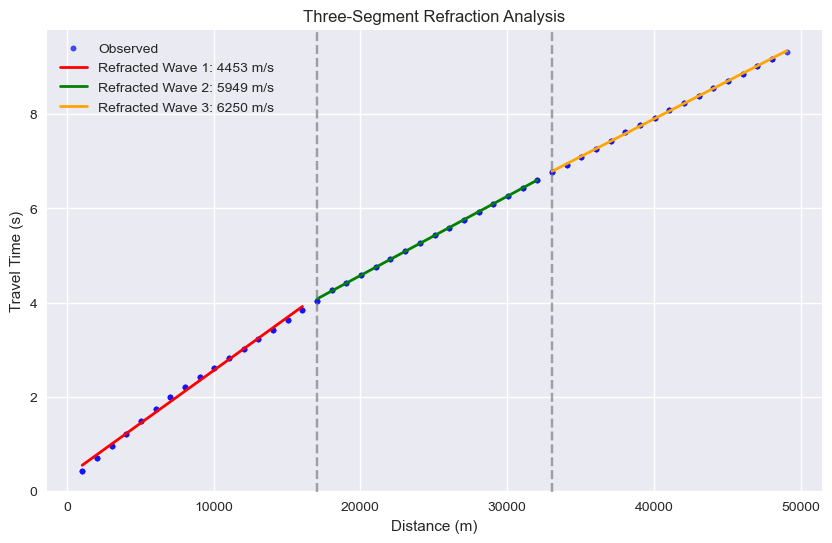

Velocities: 4453, 5949, 6250 m/s


In [12]:
# Load data
refraction_df = pd.read_csv('yellowstone_refractions.csv')
x = refraction_df['X distance [m]'].values
t = refraction_df['P wave arrivals [s]'].values

# Manual breakpoints (adjust these if needed)
break1 = len(x) // 3      
break2 = 2 * len(x) // 3  

# Fit 3 segments
segments = [(0, break1), (break1, break2), (break2, len(x))]
models = []
velocities = []
colors = ['red', 'green', 'orange']

for i, (start, end) in enumerate(segments):
    x_seg = x[start:end].reshape(-1, 1) 
    t_seg = t[start:end]
    
    model = LinearRegression().fit(x_seg, t_seg)
    models.append(model)
    
    slope = model.coef_[0]
    velocity = 1 / slope
    velocities.append(velocity)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(x, t, color='blue', alpha=0.7, s=15, label='Observed')

# Plot segments
for i, (start, end) in enumerate(segments):
    x_seg = x[start:end]
    pred = models[i].predict(x_seg.reshape(-1, 1))
    plt.plot(x_seg, pred, color=colors[i], linewidth=2, label=f'Refracted Wave {i+1}: {velocities[i]:.0f} m/s')

# Mark breakpoints
plt.axvline(x[break1], color='gray', linestyle='--', alpha=0.7) 
plt.axvline(x[break2], color='gray', linestyle='--', alpha=0.7)

plt.xlabel('Distance (m)')
plt.ylabel('Travel Time (s)')
plt.title('Three-Segment Refraction Analysis')
plt.legend()
plt.grid(True)
plt.savefig("refraction_three_segment_fit.png", dpi=300, bbox_inches='tight') 
plt.show()

# Results
print(f"Velocities: {velocities[0]:.0f}, {velocities[1]:.0f}, {velocities[2]:.0f} m/s")

## 2. Seismic Reflection Analysis

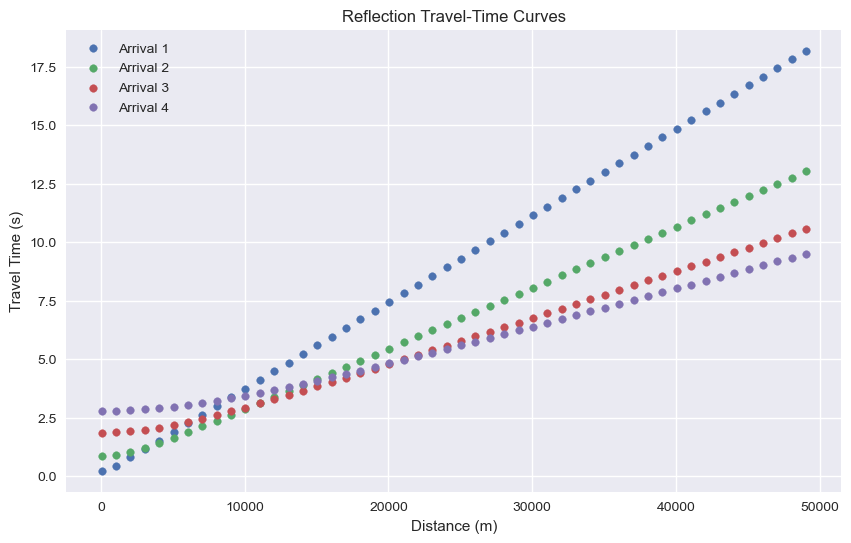

In [11]:
# Plot reflection travel times for each arrival
plt.figure(figsize=(10, 6))
for i in range(1, 5):
    plt.scatter(reflection_df['X distance [m]'], reflection_df[f'P wave arrival {i} [s]'], label=f"Arrival {i}", s=30)
plt.xlabel("Distance (m)")
plt.ylabel("Travel Time (s)")
plt.title("Reflection Travel-Time Curves")
plt.legend()
plt.grid(True)
plt.show()

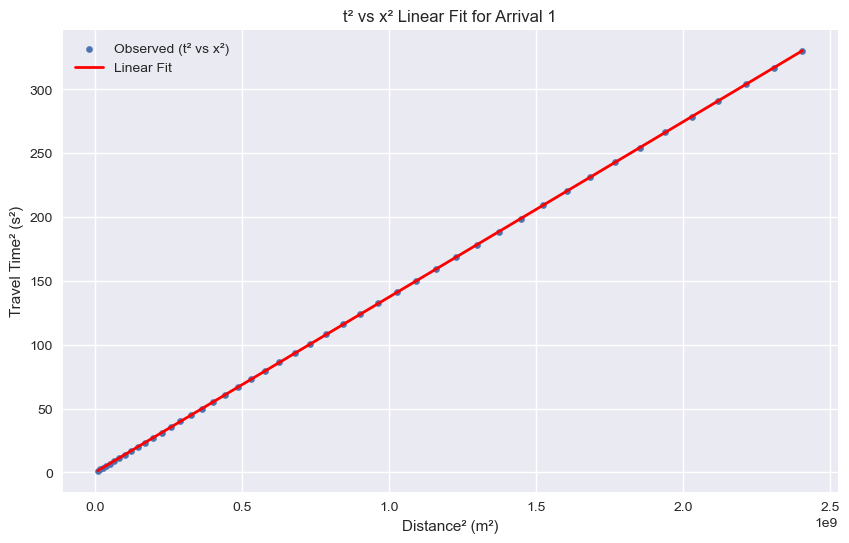

Estimated reflection velocity v: 2699.07 m/s
Estimated reflection depth h:    305.13 m


In [50]:
# Load reflection data
reflection_df = pd.read_csv('yellowstone_reflections.csv')

# Extract distance and travel time for Arrival 1
x_reflect = reflection_df['X distance [m]'].values
t_reflect = reflection_df['P wave arrival 1 [s]'].values

# Remove first few points to fix intercept
skip = 3  
x_reflect = x_reflect[skip:] 
t_reflect = t_reflect[skip:]

# Square of time and distance
x_squared = x_reflect**2
t_squared = t_reflect**2

# Fit a linear model: t^2 = A + B x^2
X = x_squared.reshape(-1, 1)
y = t_squared.reshape(-1, 1)
model = LinearRegression().fit(X, y)
A = model.intercept_[0]
B = model.coef_[0][0]

# Calculate v and h
v_est = 1 / np.sqrt(B)
h_est = v_est * np.sqrt(A) / 2
# Plot t^2 vs x^2
plt.figure(figsize=(10, 6))
plt.scatter(x_squared, t_squared, label="Observed (t² vs x²)", s=20)
plt.plot(x_squared, model.predict(X), color='red', label="Linear Fit", linewidth=2)
plt.xlabel("Distance² (m²)")
plt.ylabel("Travel Time² (s²)")
plt.title("t² vs x² Linear Fit for Arrival 1")
plt.legend()
plt.grid(True)
plt.savefig("reflection_arrival_1_fit.png", dpi=150, bbox_inches='tight')
plt.show()

# Print results
print(f"Estimated reflection velocity v: {v_est:.2f} m/s")
print(f"Estimated reflection depth h:    {h_est:.2f} m")

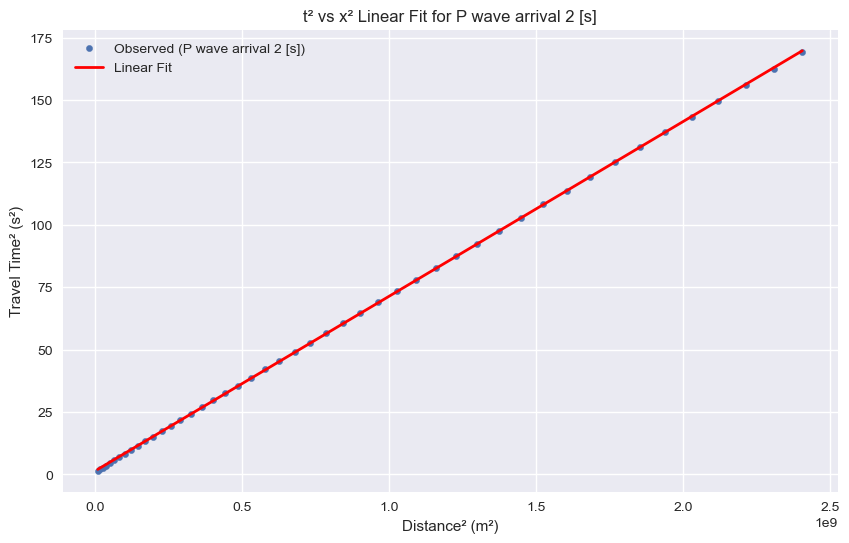

P wave arrival 2 [s]
Estimated reflection velocity v ≈ 3779.42 m/s
Estimated reflection depth h ≈ 2185.99 m


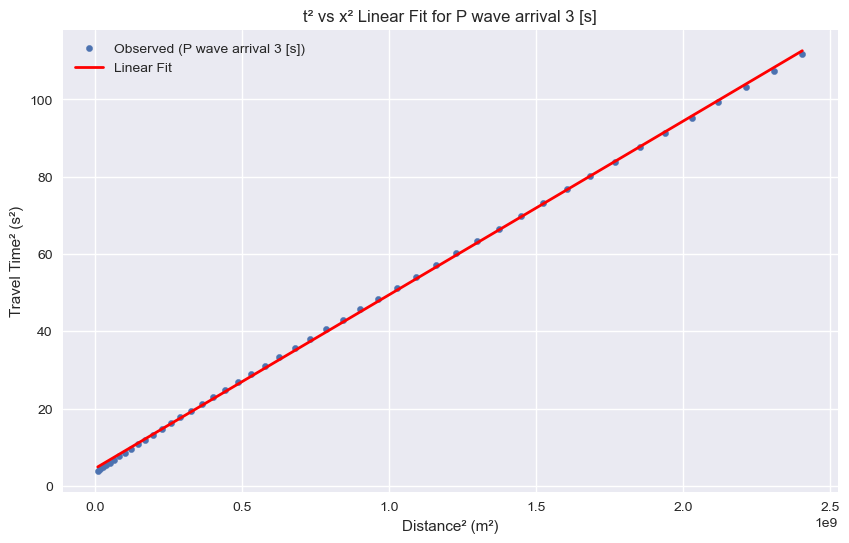

P wave arrival 3 [s]
Estimated reflection velocity v ≈ 4716.98 m/s
Estimated reflection depth h ≈ 4995.12 m


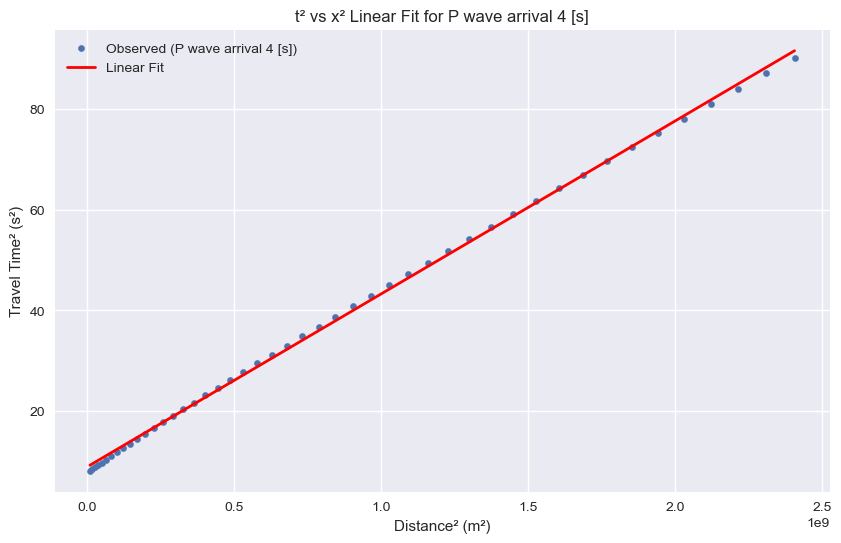

P wave arrival 4 [s]
Estimated reflection velocity v ≈ 5395.57 m/s
Estimated reflection depth h ≈ 8065.63 m


In [54]:
# Analyze arrivals 2, 3, 4
for i in range(2, 5):
    arrival_label = f'P wave arrival {i} [s]'  
    t_reflect = reflection_df[arrival_label].values[skip:]  # Skip first few points
    t_squared = t_reflect ** 2
    
    # Linear regression: t^2 = A + B x^2
    X = x_squared.reshape(-1, 1)
    y = t_squared.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    A = model.intercept_[0]
    B = model.coef_[0][0]
    
    # Calculate velocity and depth
    v_est = 1 / np.sqrt(B)
    h_est = v_est * np.sqrt(A) / 2 
    
    # Plot t^2 vs x^2 with linear fit for each arrival
    plt.figure(figsize=(10, 6))
    plt.scatter(x_squared, t_squared, label=f'Observed ({arrival_label})', s=20)
    plt.plot(x_squared, model.predict(X), color='red', label='Linear Fit', linewidth=2)
    plt.xlabel("Distance² (m²)")
    plt.ylabel("Travel Time² (s²)")
    plt.title(f"t² vs x² Linear Fit for {arrival_label}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"reflection_arrival_{i}_fit.png", dpi=150, bbox_inches='tight')  
    plt.show() 
    
    # Print result
    print(f"{arrival_label}")
    print(f"Estimated reflection velocity v ≈ {v_est:.2f} m/s")
    print(f"Estimated reflection depth h ≈ {h_est:.2f} m")

## 3. Gravity Analysis

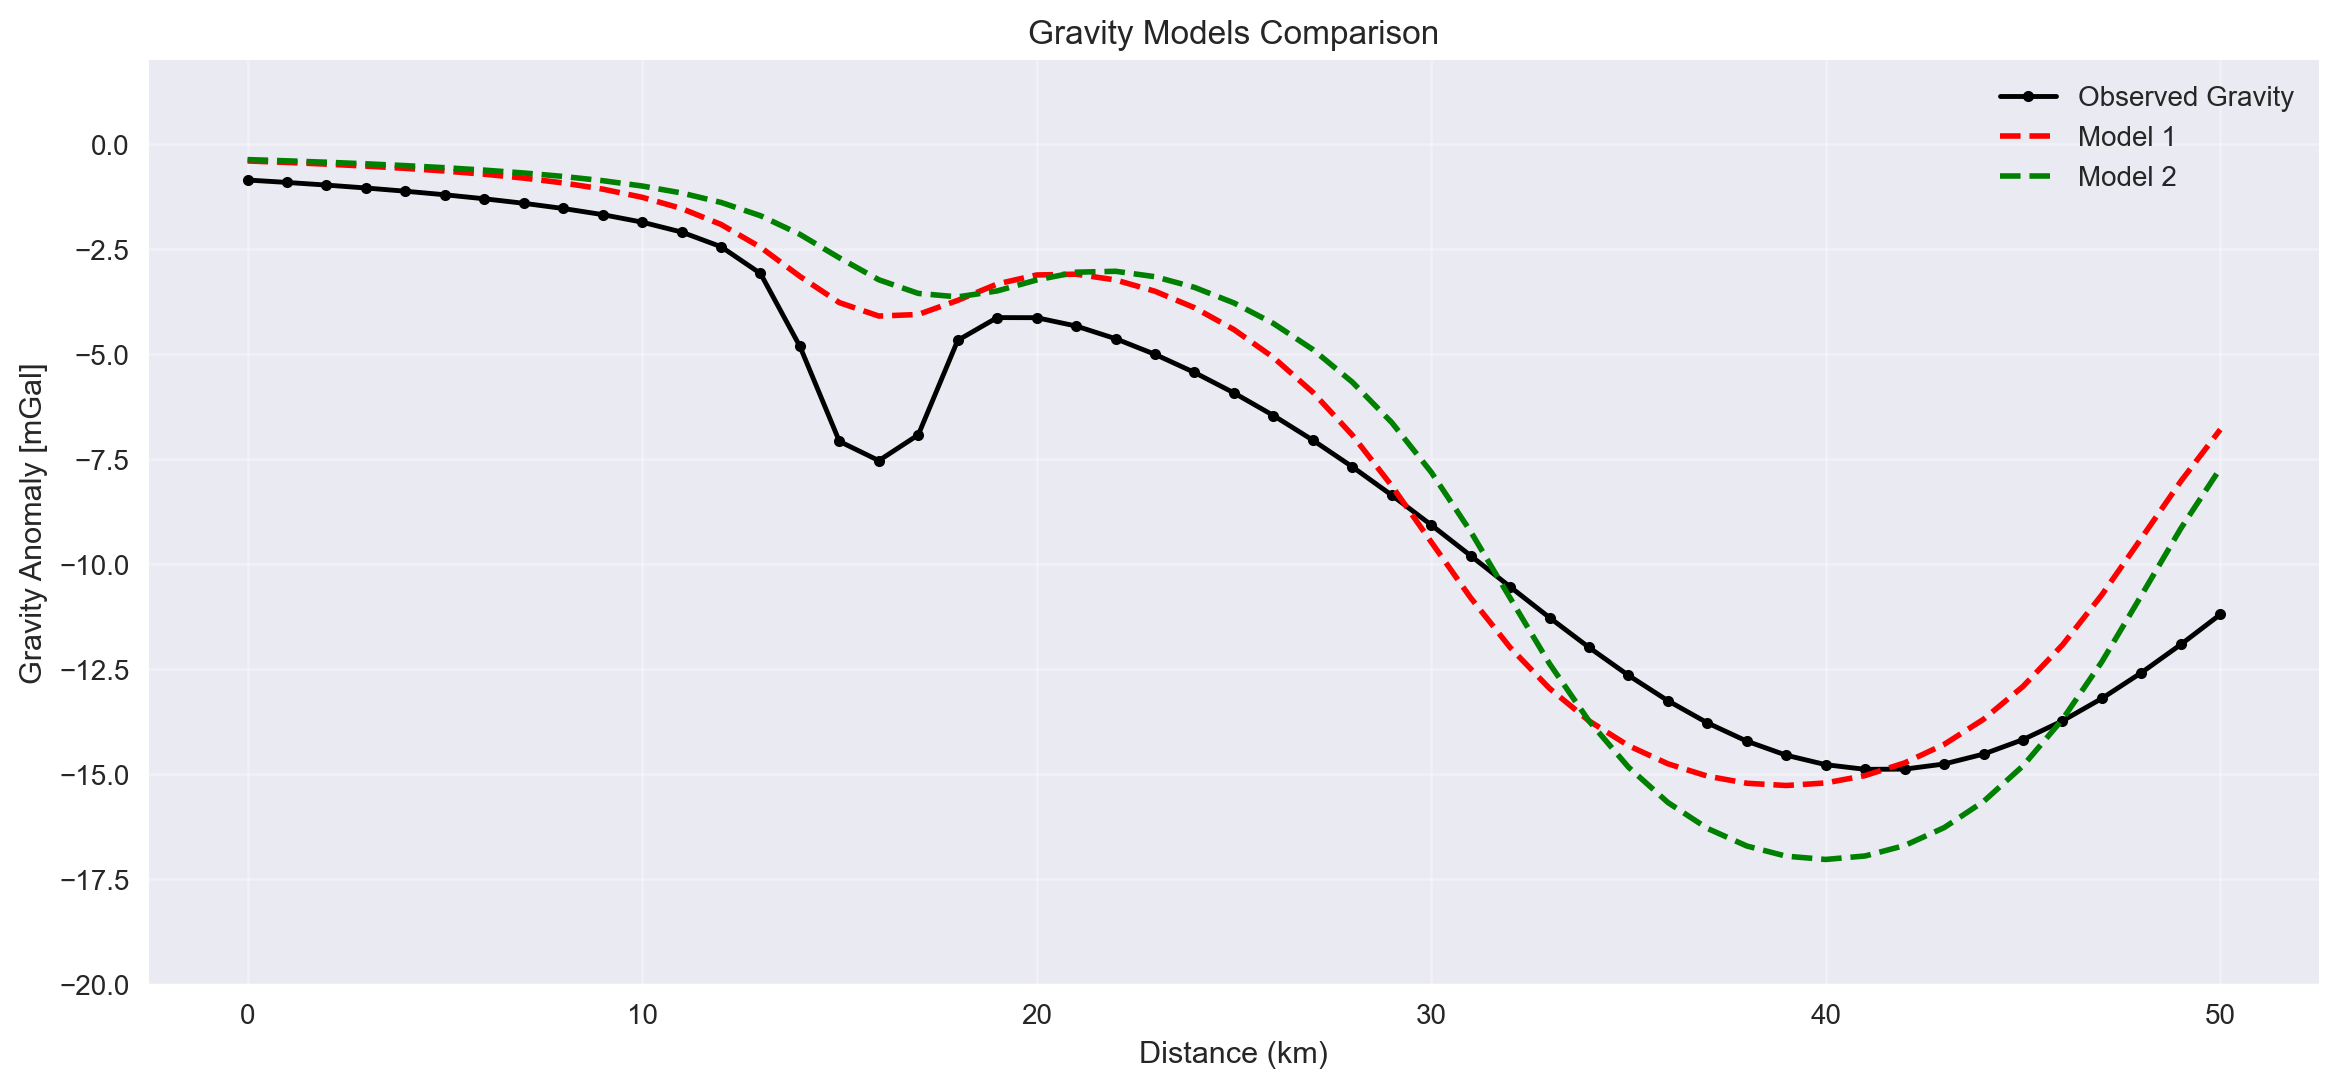

Model 1 RMS: 1.591 mGal
Model 2 RMS: 1.856 mGal


In [20]:
# Set up coordinates
region = (0, 50000, 0, 50000)  
shape = (51, 51)                
height = 0                      
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

# Load data
data = pd.read_csv("yellowstone_gravity.csv")
x_obs = data['X distance [m]'].values
g_obs = data['Gravity Anomaly [mGal]'].values

# MODEL 1
blocks_1 = [
    [14000, 18000, 0, 50000, -4000, -1500],   # Sharp feature at 15-17 km
    [30000, 48000, 0, 50000, -9500, -2500]    # Main anomaly
]
density_1 = [-65, -85]

# MODEL 2
blocks_2 = [
    [15000, 19500, 0, 50000, -3500, -1800],   # Narrow sharp block
    [32000, 48000, 0, 50000, -10000, -2200]   # Main block
]
density_2 = [-70, -90]

# Calculate models
result_g1 = hm.prism_gravity(coordinates, blocks_1, density_1, field='g_z')
model_1_profile = result_g1[25, :]

result_g2 = hm.prism_gravity(coordinates, blocks_2, density_2, field='g_z')
model_2_profile = result_g2[25, :]

x_model = np.linspace(0, 50000, 51)

# Plot all models together
plt.figure(figsize=(14, 6), dpi=200)
plt.plot(x_obs/1000, g_obs, 'ko-', label='Observed Gravity', markersize=4)
plt.plot(x_model/1000, model_1_profile, 'r--', label='Model 1', linewidth=2)
plt.plot(x_model/1000, model_2_profile, 'g--', label='Model 2', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Gravity Anomaly [mGal]')
plt.title('Gravity Models Comparison')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(-20, 2)
plt.savefig('gravity_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate RMS
rms_1 = np.sqrt(np.mean((g_obs - model_1_profile)**2))
rms_2 = np.sqrt(np.mean((g_obs - model_2_profile)**2))

print(f"Model 1 RMS: {rms_1:.3f} mGal")
print(f"Model 2 RMS: {rms_2:.3f} mGal")

## 4. Magnetic Analysis

RMS Misfit: 3.035 nT


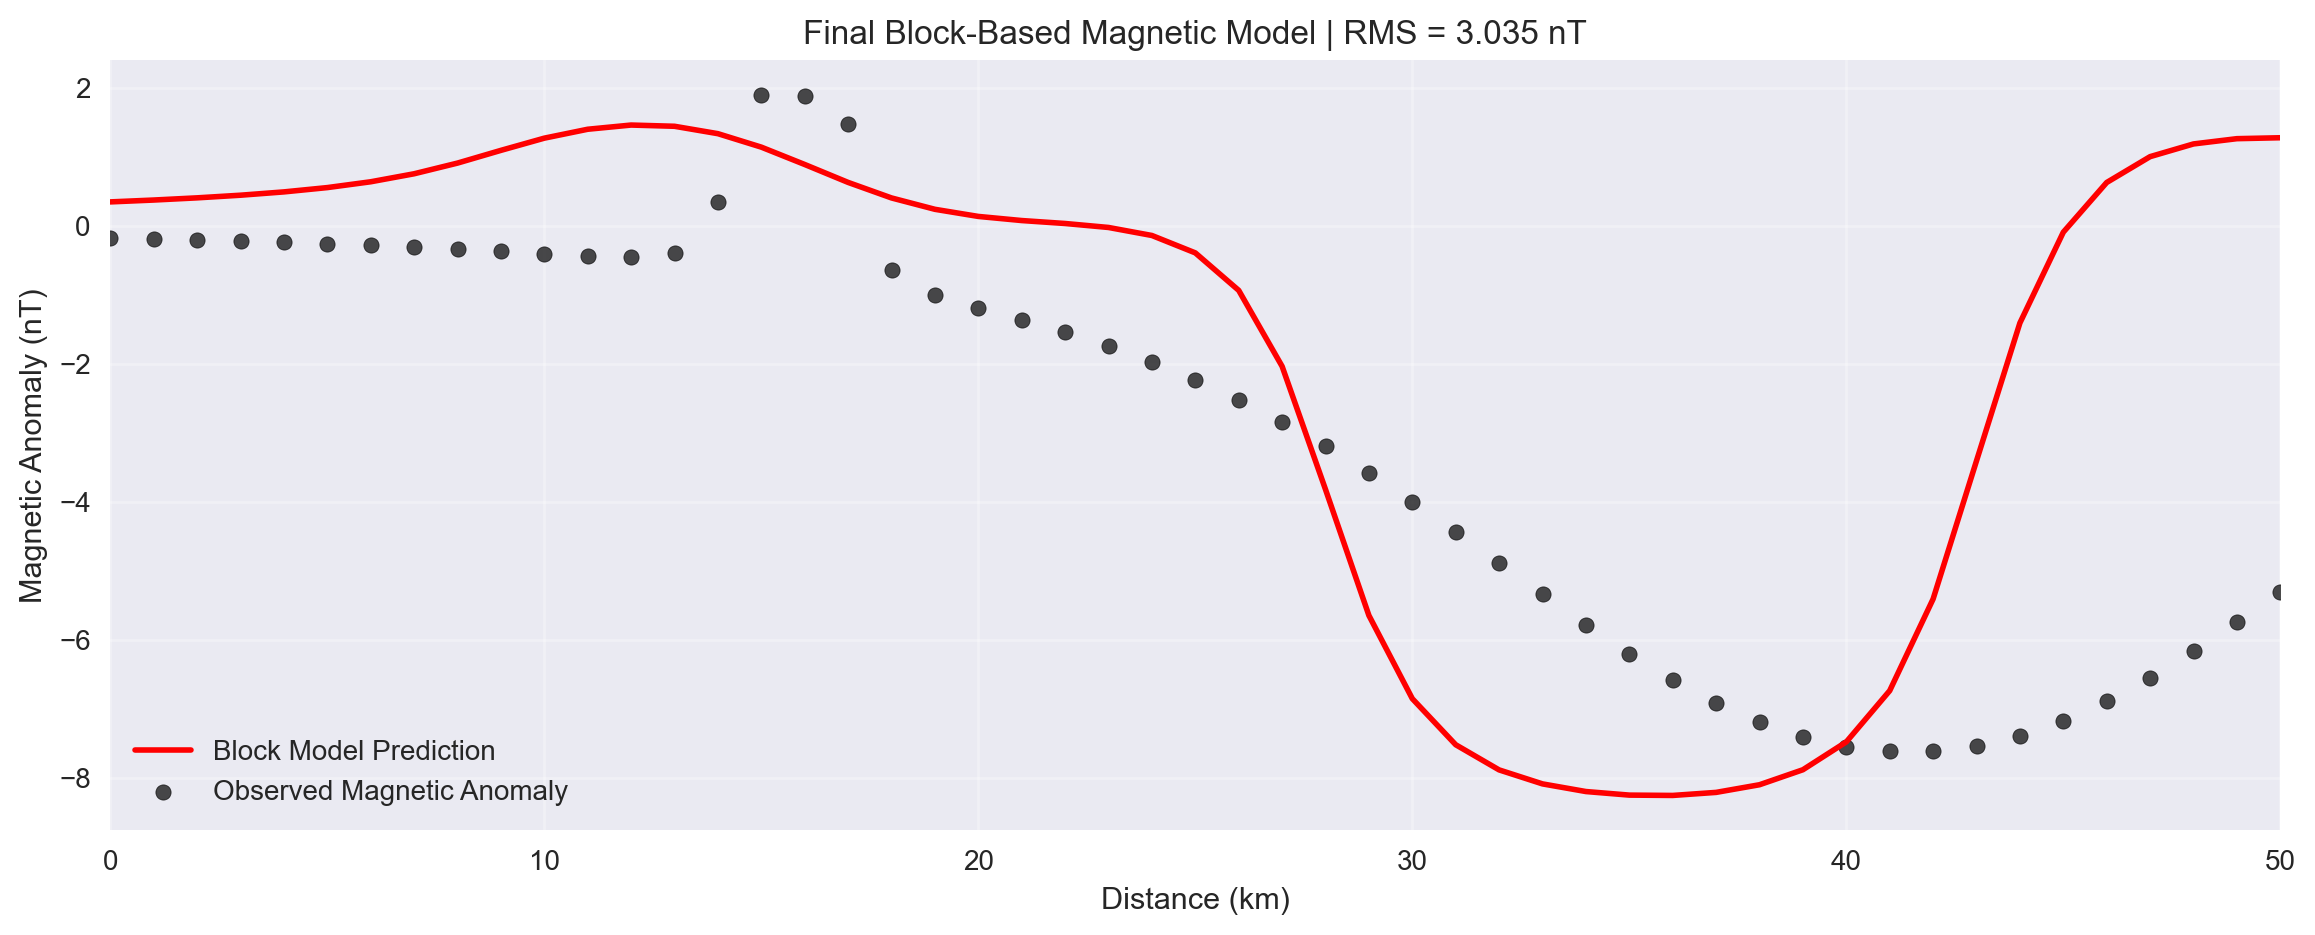


Block Parameters:
Block 1: x=[9.0, 15.0] km, depth=[3.0, 9.0] km, M_z=0.003
Block 2: x=[17.0, 27.0] km, depth=[4.0, 8.0] km, M_z=-0.008
Block 3: x=[28.0, 43.0] km, depth=[2.0, 14.0] km, M_z=-0.024


In [22]:
# Load magnetic anomaly data
data = pd.read_csv("yellowstone_magnetics.csv")
x_obs = data["X distance [m]"].values
mag_obs = data["Magnetic Anomaly [nT]"].values

# Set up region and observation grid
region = (0, 50000, 0, 50000) # x_min, x_max, y_min, y_max
shape = (51, 51)
height = 0 # Observation at surface
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

# Define block model
blocks = [
    [9000, 15000, 0, 50000, -9000, -3000], # Block 1 
    [17000, 27000, 0, 50000, -8000, -4000], # Block 2
    [28000, 43000, 0, 50000, -14000, -2000] # Block 3 
]

# Magnetization values
magnetization = np.array([
    [0, 0, 0.003],    # Block 1
    [0, 0, -0.008],   # Block 2
    [0, 0, -0.024]    # Block 3
]) 

# Compute magnetic anomaly
b_e, b_n, b_z = hm.prism_magnetic(coordinates, blocks, magnetization.T, field="b")

# Extract model profile
model_profile = b_z[25, :] # Extract along x-direction at y=25

# Calculate RMS error
rms = np.sqrt(np.mean((model_profile - mag_obs)**2))
print(f"RMS Misfit: {rms:.3f} nT")

# Plot observed vs modeled 
plt.figure(figsize=(14, 5), dpi=200)
plt.plot(x_obs/1000, model_profile, label='Block Model Prediction', color='red', linewidth=2)
plt.scatter(x_obs/1000, mag_obs, label='Observed Magnetic Anomaly', color='black', s=30, alpha=0.7)
plt.xlabel("Distance (km)")
plt.ylabel("Magnetic Anomaly (nT)")
plt.title(f"Final Block-Based Magnetic Model | RMS = {rms:.3f} nT")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 50)
plt.savefig("magnetic_model.png", bbox_inches="tight", dpi=300)
plt.show()

# Print block parameters summary 
print("\nBlock Parameters:")
for i, block in enumerate(blocks):
    print(f"Block {i+1}: x=[{block[0]/1000:.1f}, {block[1]/1000:.1f}] km, "
          f"depth=[{-block[5]/1000:.1f}, {-block[4]/1000:.1f}] km, "
          f"M_z={magnetization[i,2]:.3f}")